In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Select, RangeSlider, LinearAxis, Div, Span, CustomJS, RadioButtonGroup
from bokeh.layouts import column, row
from datetime import  datetime

import statsmodels

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

import matplotlib.dates as mdates

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from matplotlib.patches import Circle

In [2]:
df = pd.read_csv("us-states.csv", parse_dates=["date"])

# Examine structure
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

print("\nLast few rows:")
print(df.tail())

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Basic data exploration
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of unique states: {df['state'].nunique()}")
print(f"Total days: {df['date'].nunique()}")

# Basic statistics
print("\nBasic statistics for deaths:")
print(df['deaths'].describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (61942, 5)

Columns: ['date', 'state', 'fips', 'cases', 'deaths']

First few rows:
        date       state  fips  cases  deaths
0 2020-01-21  Washington    53      1       0
1 2020-01-22  Washington    53      1       0
2 2020-01-23  Washington    53      1       0
3 2020-01-24    Illinois    17      1       0
4 2020-01-24  Washington    53      1       0

Last few rows:
            date          state  fips    cases  deaths
61937 2023-03-23       Virginia    51  2298300   23782
61938 2023-03-23     Washington    53  1940704   15905
61939 2023-03-23  West Virginia    54   645710    8132
61940 2023-03-23      Wisconsin    55  2014524   16485
61941 2023-03-23        Wyoming    56   185800    2014

Date range: 2020-01-21 00:00:00 to 2023-03-23 00:00:00
Number of unique states: 56
Total days: 1158

Basic statistics for deaths:
count     61942.000000
mean      11779.067499
std       17345.774849
min           0.000000
25%        1171.000000
50%        5035.000000
75%       1

## Part IV : Maps

**Task:** Using geopandas,  Create a choropleth map showing total COVID-19 deaths by state for continental US

After merge: 49 states
States with data: 49
States with zero: 0
Death range: 939 to 104277

Top 5 states:
            NAME  total_deaths
11    California        104277
10         Texas         94518
23       Florida         87141
20      New York         80138
4   Pennsylvania         50701


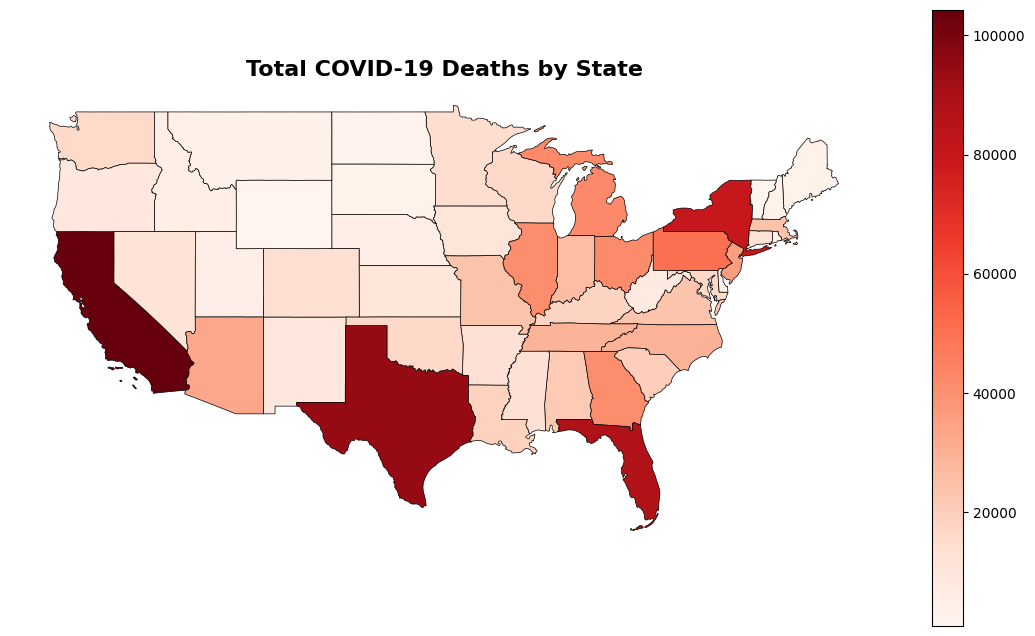

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Download states
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
us_states = gpd.read_file(url)

# Keep only continental US
exclude = ['PR', 'VI', 'GU', 'MP', 'AS', '72', '78', '66', '69', '60', 'AK', 'HI']
continental = us_states[~us_states['STUSPS'].isin(exclude)]

# Calculate total deaths by state
df['date'] = pd.to_datetime(df['date'])
state_deaths = df.groupby('state')['deaths'].max().reset_index()
state_deaths.columns = ['state', 'total_deaths']

# Merge using state NAME not code!
map_data = continental.merge(state_deaths, left_on='NAME', right_on='state', how='left')
map_data['total_deaths'] = map_data['total_deaths'].fillna(0)

print(f"After merge: {len(map_data)} states")
print(f"States with data: {(map_data['total_deaths'] > 0).sum()}")
print(f"States with zero: {(map_data['total_deaths'] == 0).sum()}")
print(f"Death range: {map_data['total_deaths'].min():.0f} to {map_data['total_deaths'].max():.0f}")

print("\nTop 5 states:")
print(map_data.nlargest(5, 'total_deaths')[['NAME', 'total_deaths']])

# Simple plot
fig, ax = plt.subplots(figsize=(14, 8))
map_data.plot(
    column='total_deaths',
    ax=ax,
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    legend=True
)
ax.axis('off')
plt.title('Total COVID-19 Deaths by State', fontsize=16, fontweight='bold')
plt.show()

**Task:** Create a map showing BOTH total deaths AND per-capita death rate

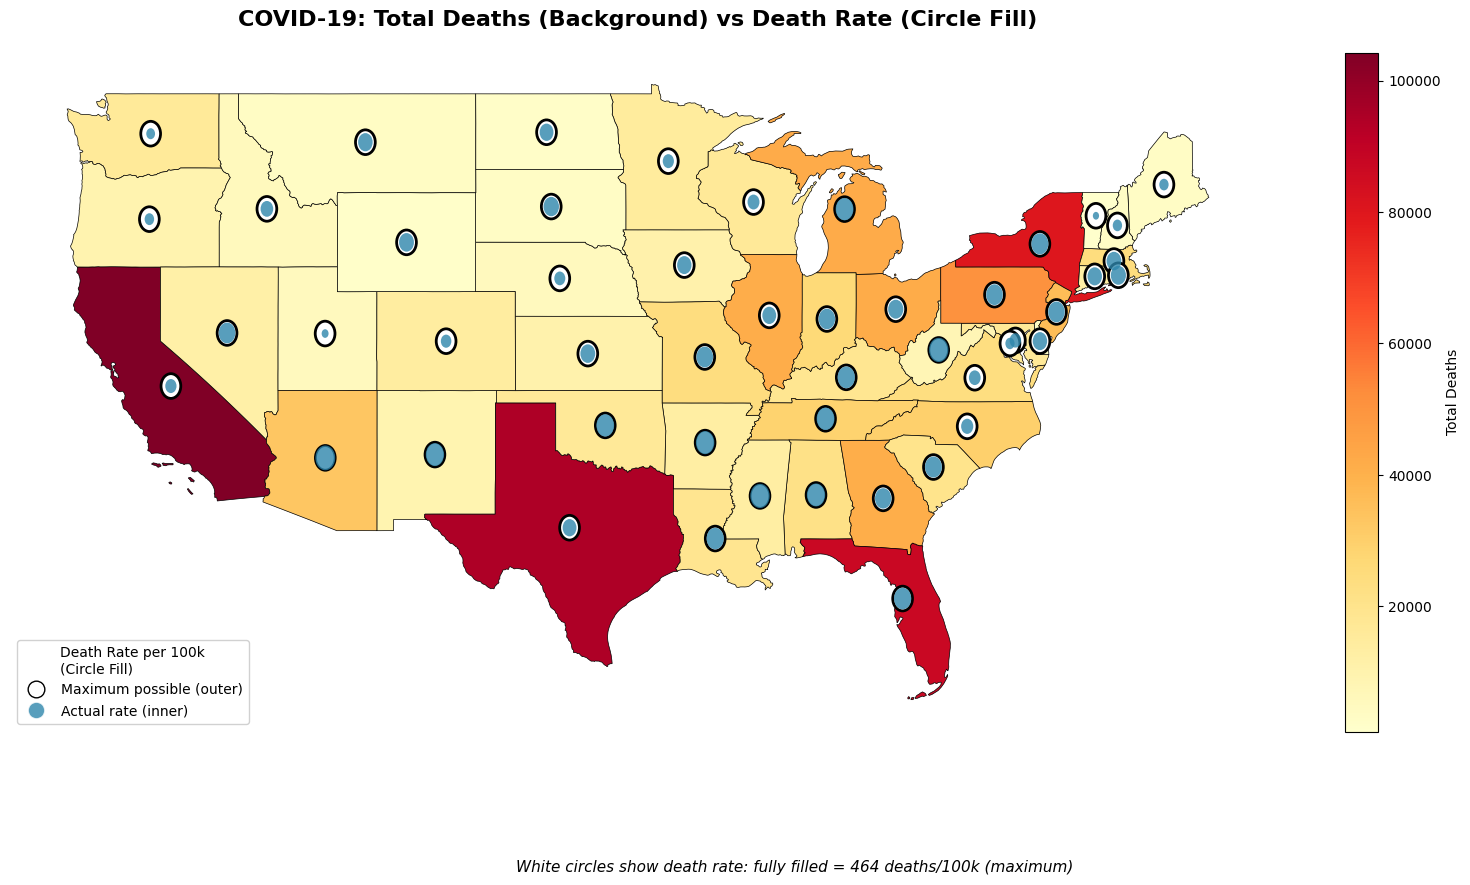

=== TWO-DIMENSIONAL ANALYSIS ===

Maximum death rate: 464.1 per 100k

Highest TOTAL deaths (background):
            NAME  total_deaths  deaths_per_100k
11    California        104277       263.737194
10         Texas         94518       324.297006
23       Florida         87141       404.588371
20      New York         80138       396.698244
4   Pennsylvania         50701       389.926708

Highest RATE per 100k (circle fill):
             NAME  total_deaths  deaths_per_100k
47        Arizona         33190       464.098311
39    Mississippi         13431       453.554022
44  West Virginia          8132       453.360510
8        Arkansas         13068       433.933118
7         Alabama         21631       430.529435


In [4]:
# Download states
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
us_states = gpd.read_file(url)

# Keep only continental US
exclude = ['PR', 'VI', 'GU', 'MP', 'AS', '72', '78', '66', '69', '60', 'AK', 'HI']
continental = us_states[~us_states['STUSPS'].isin(exclude)]

# State populations (2020 estimates)
populations = {
    'California': 39538223, 'Texas': 29145505, 'Florida': 21538187, 'New York': 20201249,
    'Pennsylvania': 13002700, 'Illinois': 12812508, 'Ohio': 11799448, 'Georgia': 10711908,
    'North Carolina': 10439388, 'Michigan': 10077331, 'New Jersey': 9288994, 'Virginia': 8631393,
    'Washington': 7705281, 'Arizona': 7151502, 'Massachusetts': 7029917, 'Tennessee': 6910840,
    'Indiana': 6785528, 'Maryland': 6177224, 'Missouri': 6154913, 'Wisconsin': 5893718,
    'Colorado': 5773714, 'Minnesota': 5706494, 'South Carolina': 5118425, 'Alabama': 5024279,
    'Louisiana': 4657757, 'Kentucky': 4505836, 'Oregon': 4237256, 'Oklahoma': 3959353,
    'Connecticut': 3605944, 'Utah': 3271616, 'Iowa': 3190369, 'Nevada': 3104614,
    'Arkansas': 3011524, 'Mississippi': 2961279, 'Kansas': 2937880, 'New Mexico': 2117522,
    'Nebraska': 1961504, 'Idaho': 1839106, 'West Virginia': 1793716, 'Hawaii': 1455271,
    'New Hampshire': 1377529, 'Maine': 1362359, 'Montana': 1084225, 'Rhode Island': 1097379,
    'Delaware': 989948, 'South Dakota': 886667, 'North Dakota': 779094, 'Alaska': 733391,
    'District of Columbia': 689545, 'Vermont': 643077, 'Wyoming': 576851
}

# Calculate deaths by state
df['date'] = pd.to_datetime(df['date'])
state_deaths = df.groupby('state')['deaths'].max().reset_index()
state_deaths.columns = ['state', 'total_deaths']

# Add population and calculate rate
state_deaths['population'] = state_deaths['state'].map(populations)
state_deaths['deaths_per_100k'] = (state_deaths['total_deaths'] / state_deaths['population']) * 100000

# Merge with map
map_data = continental.merge(state_deaths, left_on='NAME', right_on='state', how='left')
map_data = map_data.dropna(subset=['total_deaths'])

# PROJECT to proper CRS before calculating centroids
map_data_projected = map_data.to_crs('EPSG:5070')
map_data_projected['centroid'] = map_data_projected.centroid
centroids_original = map_data_projected['centroid'].to_crs(map_data.crs)

# Normalize death rate to 0-1 for circle sizing
max_rate = map_data['deaths_per_100k'].max()
map_data['rate_normalized'] = map_data['deaths_per_100k'] / max_rate

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Base map - choropleth by total deaths
map_data.plot(
    column='total_deaths',
    ax=ax,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': 'Total Deaths', 'shrink': 0.7}
)

# Overlay concentric circles
outer_radius = 0.5  # Base radius in map coordinates

for centroid, rate_norm, rate_actual in zip(centroids_original, 
                                              map_data['rate_normalized'],
                                              map_data['deaths_per_100k']):
    # White outer circle (fixed size)
    outer_circle = Circle(
        (centroid.x, centroid.y),
        outer_radius,
        facecolor='white',
        edgecolor='black',
        linewidth=2,
        zorder=10
    )
    ax.add_patch(outer_circle)
    
    # Blue inner circle (radius proportional to death rate)
    # Area proportional means radius proportional to sqrt(rate)
    inner_radius = outer_radius * rate_norm
    inner_circle = Circle(
        (centroid.x, centroid.y),
        inner_radius,
        facecolor='#2E86AB',  # Nice blue
        edgecolor='none',
        alpha=0.8,
        zorder=11
    )
    ax.add_patch(inner_circle)

# Add legend explanation
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
           markeredgecolor='black', markersize=12, linewidth=2, label='Maximum possible (outer)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2E86AB', 
           alpha=0.8, markersize=12, label='Actual rate (inner)'),
]

ax.legend(handles=legend_elements, loc='lower left', 
         title='Death Rate per 100k\n(Circle Fill)', fontsize=10, framealpha=0.9)

ax.axis('off')
plt.title('COVID-19: Total Deaths (Background) vs Death Rate (Circle Fill)', 
          fontsize=16, fontweight='bold', pad=20)

fig.text(0.5, 0.02, 
         f'White circles show death rate: fully filled = {max_rate:.0f} deaths/100k (maximum)',
         ha='center', fontsize=11, style='italic')

plt.tight_layout()
plt.show()

# Print insights
print("=== TWO-DIMENSIONAL ANALYSIS ===\n")
print(f"Maximum death rate: {max_rate:.1f} per 100k\n")
print("Highest TOTAL deaths (background):")
print(map_data.nlargest(5, 'total_deaths')[['NAME', 'total_deaths', 'deaths_per_100k']])
print("\nHighest RATE per 100k (circle fill):")
print(map_data.nlargest(5, 'deaths_per_100k')[['NAME', 'total_deaths', 'deaths_per_100k']])